In [1]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import scipy

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [2]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv      11_groups.csv      product_groups.csv
10_groups.csv      bad_ids.csv


In [3]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [4]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [5]:
bad_ids = pd.read_csv('./data/bad_ids.csv', delimiter=',', encoding='windows-1251', index_col=0)
bad_ids.head()

,id_card
0,806096
1,1438102
2,72344
3,427981
4,1528414


In [6]:
filtered = g_9[~g_9['id_card'].isin(bad_ids['id_card'])]
filtered.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [7]:
g_9.describe()

,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
count,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07
mean,1.170384e+07,7.765869e+05,8.446032e+05,1.763064e+04,1.045977e+04,1.427065e+00,1.149112e+02,7.614348e-02,8.925476e+03
std,6.760102e+06,2.032896e+06,5.388947e+05,1.103226e+04,8.794764e+03,3.101411e+01,1.072201e+02,2.652276e-01,4.681248e+03
min,2.000000e+00,0.000000e+00,0.000000e+00,4.600000e+01,-9.999000e+03,-2.755000e+00,-1.022110e+03,0.000000e+00,-9.999000e+03
25%,5.848724e+06,0.000000e+00,3.650470e+05,1.452600e+04,3.850000e+02,1.000000e+00,4.800000e+01,0.000000e+00,1.002600e+04
50%,1.170182e+07,0.000000e+00,8.150010e+05,1.943500e+04,1.358100e+04,1.000000e+00,8.900000e+01,0.000000e+00,1.006800e+04
75%,1.755596e+07,0.000000e+00,1.288708e+06,2.455800e+04,1.630400e+04,1.000000e+00,1.501100e+02,0.000000e+00,1.011600e+04
max,2.341787e+07,6.673056e+06,1.944074e+06,3.866000e+04,2.194300e+04,5.000000e+03,3.840000e+04,1.000000e+00,5.219400e+04


In [8]:
filtered.describe()

,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
count,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07,3.846600e+07
mean,1.170401e+07,7.902277e+05,8.480062e+05,1.759290e+04,1.042237e+04,1.247657e+00,1.158831e+02,6.789276e-02,8.941671e+03
std,6.760030e+06,2.047825e+06,5.411127e+05,1.101772e+04,8.824200e+03,1.692223e+01,1.076925e+02,2.515618e-01,4.650781e+03
min,2.000000e+00,0.000000e+00,0.000000e+00,4.600000e+01,-9.999000e+03,-2.755000e+00,-1.022110e+03,0.000000e+00,-9.999000e+03
25%,5.848967e+06,0.000000e+00,3.663850e+05,1.452600e+04,3.790000e+02,1.000000e+00,4.900000e+01,0.000000e+00,1.002600e+04
50%,1.170211e+07,0.000000e+00,8.137320e+05,1.943400e+04,1.358100e+04,1.000000e+00,9.000000e+01,0.000000e+00,1.006800e+04
75%,1.755540e+07,0.000000e+00,1.295525e+06,2.446600e+04,1.630400e+04,1.000000e+00,1.520000e+02,0.000000e+00,1.011600e+04
max,2.341787e+07,6.672847e+06,1.944074e+06,3.866000e+04,2.194300e+04,5.000000e+03,3.840000e+04,1.000000e+00,5.219400e+04


# I don't have enough machine resources to load whole 10GB, so I used only g_9

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

In [9]:
grouped = filtered.groupby('id_doc')[['sum', 'is_green']]
sums = grouped.sum()


Check if there is a statistical difference between means of:
1) Sums of purchases with discounted goods

2) Without discounted goods

In [10]:
scipy.stats.ttest_ind(sums[sums['is_green'] > 0]['sum'], sums[sums['is_green'] == 0]['sum'], equal_var = False)

Ttest_indResult(statistic=-76.41968791538956, pvalue=0.0)

The test's pvalue is 0, so the statistical difference is there

Let's also consider correletion between the sum of purcase and amount of 'green' goods in it

In [11]:
print("Non normalized", scipy.stats.pearsonr(sums['sum'], sums['is_green']))

s = grouped.sum()
s['is_green'] /= grouped.count()['is_green']

print("Normalized", scipy.stats.pearsonr(s['sum'], s['is_green']))

Non normalized (0.03786160208996857, 0.0)
Normalized (-0.11211405758848857, 0.0)


We have a positive correlation when we don't normalize the amount of green goods per check.
But it is logical, as more goods you buy, more green goods you buy.

But if we divide amount of green goods by total amount of goods in the cart, and check the correlation then,
we see that there is an inverse correlation between the sum of order and % of green goods in it

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [12]:
by_day = filtered.groupby('id_doc')[['date']].first()
print(by_day.head())

by_day.index = pd.to_datetime(by_day['date'])

by_day = by_day.groupby(by_day.index.day).count()


                       date
id_doc                     
2       2020-09-21 17:14:45
4       2020-09-24 21:07:19
5       2020-09-22 19:25:17
16      2020-09-14 18:53:45
18      2020-09-18 21:24:04


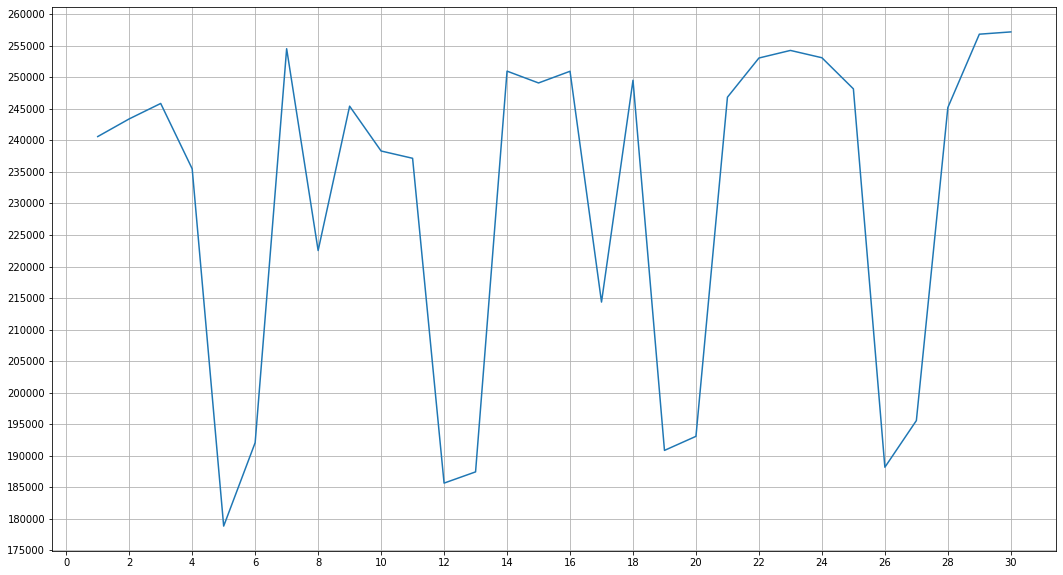

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.locator_params(nbins=30)
plt.plot(by_day.index, by_day['date'])
plt.grid()

From plot we can see, that the only periodic event happens every week (5-th, 12-th, 19-th, 26-th)
But there are no spikes at the wage taking days.

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### 1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 

In [16]:
filtered.index = pd.to_datetime(filtered['date'])

In [17]:
cnts = filtered.groupby(['id_card', filtered.index.day]) \
    .first() \
    .groupby('id_card') \
    .count()

In [18]:
every_day = cnts[cnts['date'] >= 30]
every_day = every_day.index

print("First 5:", every_day[:5])
print("Total:", len(every_day))


First 5: Int64Index([5096, 6183, 57303, 58154, 121629], dtype='int64', name='id_card')
Total: 48


### 2. Average purchase sum - The customers that usually spend the same amount of money 


In [19]:
import numpy as np
from math import floor, log


docs = filtered.groupby('id_doc')[['sum', 'id_card']].agg( \
    sums=("sum", "sum"), \
    id_card=("id_card", "first") \
)

docs.groupby('id_card').mean().reset_index().sort_values('sums')

# def _rnd(x):
#     try:
#         base = 10 ** floor(log(x) / log(10))
#         return x // base * base
#     except ValueError:
#         print("Error", x)
#         return 0

# docs['sums_rnd'] = [_rnd(x) for x in docs['sums']]
bases = 10 ** np.floor(np.log(docs['sums']) / np.log(10))
docs['sums_rnd'] = np.floor_divide(docs['sums'], bases) * bases

print(docs)

docs.groupby('sums_rnd')['id_card'].apply(list)

/Users/fniyaz/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


             sums  id_card  sums_rnd
id_doc                              
2          396.00  1425208     300.0
4         1597.00  1438933    1000.0
5          254.00   293299     200.0
16         709.06   715970     700.0
18         707.00    74800     700.0
...           ...      ...       ...
23417859   346.00   781677     300.0
23417862   144.00   480091     100.0
23417864   324.00  1392399     300.0
23417867   838.24  1587296     800.0
23417869    80.00   778538      80.0

[6904825 rows x 3 columns]


sums_rnd
0.05                                                 [585840]
0.10                                                 [145090]
0.80                               [763223, 1638120, 1855771]
1.00        [1147881, 978105, 850303, 1285657, 850303, 145...
2.00        [1350472, 1422934, 900304, 616346, 1422239, 17...
3.00        [1776886, 1776886, 1776886, 620767, 774786, 17...
4.00        [1666641, 1447845, 978120, 921099, 1028660, 15...
5.00        [1086608, 184554, 962330, 402125, 430826, 1656...
6.00        [709824, 1514518, 1668435, 837435, 263506, 220...
7.00        [1326509, 1208476, 613067, 329920, 1409593, 14...
8.00        [1074283, 1050565, 203020, 1836003, 1099045, 1...
9.00        [716757, 1534975, 1277464, 1242788, 1248007, 1...
10.00       [1110006, 1100718, 1699232, 196148, 1049904, 1...
20.00       [773541, 1180951, 1407212, 409965, 868771, 127...
30.00       [1703658, 293706, 736123, 1633901, 651021, 102...
40.00       [1193372, 860021, 1482352, 344840, 135421, 670...

### 3. Orders amount - The customers grouped by the total numer of orders 

In [20]:
totals = filtered.groupby('id_doc').first() \
    .groupby('id_card').count()

totals['card_id'] = totals.index
totals = totals.groupby(['date'])['card_id'].apply(list)

totals

date
1      [1, 2, 7, 9, 13, 18, 29, 40, 44, 58, 60, 62, 7...
2      [8, 21, 24, 33, 89, 111, 132, 148, 164, 206, 2...
3      [16, 69, 70, 107, 115, 126, 143, 157, 201, 228...
4      [39, 45, 97, 118, 147, 257, 346, 356, 368, 378...
5      [4, 154, 161, 204, 256, 285, 335, 353, 375, 39...
                             ...                        
103                                   [1144271, 1808366]
104                                            [1567258]
109                                             [943480]
119                                            [1523082]
161                                             [620767]
Name: card_id, Length: 89, dtype: object

In [21]:
[(i, len(totals[i])) for i in totals.index ]

[(1, 406287),
 (2, 205028),
 (3, 135162),
 (4, 99732),
 (5, 77610),
 (6, 62453),
 (7, 51269),
 (8, 42570),
 (9, 35695),
 (10, 30623),
 (11, 25948),
 (12, 22384),
 (13, 19160),
 (14, 16585),
 (15, 14306),
 (16, 12472),
 (17, 10852),
 (18, 9378),
 (19, 8119),
 (20, 7072),
 (21, 6126),
 (22, 5498),
 (23, 4524),
 (24, 3990),
 (25, 3283),
 (26, 2772),
 (27, 2375),
 (28, 2007),
 (29, 1645),
 (30, 1387),
 (31, 1169),
 (32, 963),
 (33, 825),
 (34, 681),
 (35, 594),
 (36, 482),
 (37, 423),
 (38, 367),
 (39, 318),
 (40, 245),
 (41, 213),
 (42, 212),
 (43, 151),
 (44, 144),
 (45, 120),
 (46, 98),
 (47, 78),
 (48, 81),
 (49, 60),
 (50, 53),
 (51, 41),
 (52, 48),
 (53, 28),
 (54, 37),
 (55, 17),
 (56, 24),
 (57, 19),
 (58, 18),
 (59, 19),
 (60, 16),
 (61, 11),
 (62, 10),
 (63, 10),
 (64, 4),
 (65, 10),
 (66, 6),
 (67, 7),
 (68, 6),
 (69, 4),
 (70, 2),
 (71, 4),
 (72, 2),
 (73, 2),
 (74, 2),
 (75, 2),
 (76, 4),
 (77, 1),
 (78, 2),
 (86, 1),
 (89, 1),
 (91, 1),
 (98, 2),
 (101, 1),
 (102, 1),
 (103, 

### 4. Usual cart - The customers grouped by the product groups


In [22]:
prods = filtered.groupby('id_doc').first() \
    .groupby(['id_card', 'id_tov']).first()

prods.reset_index().groupby('id_tov')['id_card'].apply(list)

id_tov
46       [194, 359, 738, 873, 1265, 1788, 1816, 2868, 2...
52       [22, 37, 59, 95, 97, 128, 135, 152, 156, 202, ...
61       [17, 21, 28, 30, 53, 72, 91, 95, 111, 115, 128...
69       [138, 141, 202, 222, 245, 344, 482, 510, 583, ...
71       [243, 344, 738, 800, 873, 906, 951, 1585, 1943...
                               ...                        
38546                                             [564033]
38587    [2495, 12660, 81517, 133580, 547841, 773929, 1...
38618    [384250, 386255, 604589, 675849, 812958, 87277...
38645                                             [444004]
38660                                            [1454833]
Name: id_card, Length: 4765, dtype: object